# 미니 경진대회 - 선박 도장 품질 분류

본 파일은 경연대회에 참가하시는 모든 참가자 분들에게 제공되는 기본 코드입니다. 따라서 **본인이 원하는 대로 자유롭게 수정하면서 경진대회를 진행하세요.**

본 코드는 플랫폼 상에서 데이터를 불러오는 방법부터 간단한 전처리 및 머신러닝 모델링 과정을 소개하고 있습니다. 나아가서 작성한 코드의 결과를 플랫폼 상에서 바로 채점하기 위한 과정까지 확인해볼 수 있습니다.

## Library Imports

In [1]:
# # 만약 라이브러리를 설치하는 명령어가 있다면, 이 셀에 몰아두는 것을 권장합니다.
# !pip install --upgrade pip
# !pip uninstall torch torchvision torchaudio -y
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install opencv-python
# !sudo apt-get update
# !sudo apt-get install libgl1-mesa-glx -y
# !pip install albumentations
# !pip install timm
# !pip install transformers
# !pip install wandb
# !wandb.login(key="c7e355ee28e73332b4722183a035f1a153f7b6a7")
# !pip install nbformat

In [2]:
# --- 기본 및 데이터 처리 라이브러리 ---
import os  # 운영체제와 상호작용하기 위한 라이브러리 (파일 경로 등)
import random  # 무작위 샘플링 및 시드 고정을 위해 사용
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import cv2  # OpenCV, 이미지 파일을 읽고 처리하기 위한 라이브러리
import math

# --- 딥러닝(PyTorch) 관련 라이브러리 ---
import torch  # PyTorch 핵심 라이브러리
import torch.nn as nn  # 신경망 모델의 레이어나 손실 함수 등을 포함
from torch.utils.data import Dataset, DataLoader  # 커스텀 데이터셋과 데이터 로더를 위한 클래스


# --- PyTorch 최적화 및 스케줄러 ---
from torch.optim import AdamW  # Adam Optimizer의 개선된 버전, 딥러닝에서 널리 사용됨
from transformers import get_linear_schedule_with_warmup  # 학습률을 점진적으로 조정하는 스케줄러

# --- 이미지 증강 라이브러리 ---
import albumentations as A  # 빠르고 다양한 이미지 증강 기법을 제공하는 라이브러리
from albumentations.pytorch import ToTensorV2  # Albumentations 출력을 PyTorch 텐서로 변환

# --- 최신 이미지 모델 라이브러리 ---
import timm  # PyTorch Image Models, 거의 모든 최신 비전 모델을 쉽게 사용할 수 있게 해주는 라이브러리

# --- 진행 상황 시각화 ---
from tqdm.auto import tqdm  # for문 등 반복문의 진행 상황을 시각적으로 보여주는 라이브러리 (주피터 노트북용)

# --- 머신러닝 및 평가 라이브러리 ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# --- 실험 추적 및 로깅 ---
# import wandb

# --- 시각화 및 한글 설정 ---
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore")
plt.style.use('default')
mpl.rc("font", family="NanumGothic") # Linux
# mpl.rc("font", family="AppleGothic") # Mac
# mpl.rc("font", family="Malgun Gothic") # Windows
plt.rcParams["axes.unicode_minus"] = False
%matplotlib inline

/home/elicer/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Configuration

In [ ]:
# 모든 하이퍼파라미터와 설정을 이곳에서 관리합니다.
CFG = {
    # --- 기본 설정 ---
    "ROOT": Path("/mnt/elice/dataset/"),
    "SEED": 42,  # 재현성을 위한 랜덤 시드
    "DEVICE": torch.device(
        "cuda" if torch.cuda.is_available() else "cpu"
    ),  # GPU 사용 가능 여부에 따라 디바이스 설정
    # --- 모델 설정 ---
    "MODEL_NAME": "hf_hub:timm/regnety_120.sw_in12k_ft_in1k",  # timm 라이브러리에서 사용할 모델의 이름
    "NUM_CLASSES": 6,  # 분류해야 할 최종 클래스의 개수
    # --- 학습 파라미터 ---
    "IMG_SIZE": 224,  # 모델에 입력될 이미지의 크기 (가로, 세로)
    "EPOCHS": 80,  # 전체 데이터셋을 총 몇 번 학습할 것인지 (에폭)
    "LEARNING_RATE": 1e-4,  # 학습률. 모델이 얼마나 큰 폭으로 파라미터를 업데이트할지 결정
    "BATCH_SIZE": 16,  # 한 번의 반복(iteration)에서 모델에 입력할 데이터의 개수
    # --- Wandb 설정 ---
    "WANDB_DIR": None,  # wandb 실행 결과를 저장할 디렉토리 (자동 설정)
}

# # Wandb 디렉토리 자동 설정
# CFG["WANDB_DIR"] = "./wandb_runs" 
# os.makedirs(CFG["WANDB_DIR"], exist_ok=True)
# os.environ["WANDB_DIR"] = str(CFG["WANDB_DIR"])

print("✅ 환경설정 완료!")
print(f"사용할 디바이스: {CFG['DEVICE']}")
print(f"Wandb 디렉토리: {CFG['WANDB_DIR']}")

✅ 환경설정 완료!
사용할 디바이스: cuda
Wandb 디렉토리: None


## Utils

In [4]:
# 랜덤 시드 고정
def set_seed(seed=42):
    random.seed(seed)  # 파이썬 표준 난수 시드
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)  # Numpy 난수 시드
    torch.manual_seed(seed)  # PyTorch CPU 연산 난수 시드
    torch.cuda.manual_seed(seed)  # CUDA 단일 GPU 난수 시드
    torch.cuda.manual_seed_all(seed)  # CUDA 다중 GPU 난수 시드
    torch.backends.cudnn.deterministic = True  # CuDNN 연산을 결정론적으로 고정
    torch.backends.cudnn.benchmark = False  # 입력 크기 탐색 비활성화


set_seed(CFG["SEED"])
print(f"✅ 시드({CFG['SEED']}) 고정 완료!")

✅ 시드(42) 고정 완료!


In [5]:
# 평가 함수
def calculate_macro_f1_for_5_classes(preds_list, labels_list):
    """6개 클래스 예측/정답을 5개 클래스 기준으로 변환하고 Macro F1 Score를 계산합니다."""
    # 리스트를 NumPy 배열로 변환
    preds_np = np.array(preds_list)
    labels_np = np.array(labels_list)

    # 핵심 로직: 클래스 인덱스가 5인 경우, 4로 변경하여 양품 클래스를 통합.
    preds_np[preds_np == 5] = 4
    labels_np[labels_np == 5] = 4

    # Macro F1 Score를 계산합니다.
    # zero_division=0 옵션은 특정 클래스 예측이 없어 F1이 0이 될 때 경고 대신 0을 반환합니다.
    macro_f1 = f1_score(labels_np, preds_np, average="macro", zero_division=0)

    return macro_f1

## 데이터 불러오기

학습 데이터와 테스트 데이터를 불러옵니다.

ROOT 디렉토리에는 선박 도장의 손상 정도를 파악하고 도장 품질의 검사 정확도 개선을 위한 선박 도장 상태별 이미지 데이터가 저장되어 있습니다. 데이터 이미지들은 아래와 같은 6개의 폴더에 나눠져 저장되어 있습니다.

* TS_도막 손상_도막떨어짐
* TS_도막 손상_스크래치
* TS_도장 불량_부풀음
* TS_도장 불량_이물질포함
* TS_양품_선수
* TS_양품_외판

이번 경진대회의 목표는 해당 이미지들을 활용하여 선박 도장의 손상 종류를 분류하는 것입니다. 각 폴더에 존재하는 이미지들의 라벨은 다음과 같습니다.

* TS_도막 손상_도막떨어짐 -> 도막떨어짐
* TS_도막 손상_스크래치 -> 스크래치
* TS_도장 불량_부풀음 -> 부풀음
* TS_도장 불량_이물질포함 -> 이물질포함
* TS_양품_선수 -> 양품
* TS_양품_외판 -> 양품

주의: 폴더의 경로를 찾을 수 없다는 오류 메시지가 발생하는 경우 한글 폴더 이름의 인코딩 문제일 수 있습니다. 아래 베이스라인 코드의 폴더명들을 활용하세요.

In [6]:
folder_to_label = {
    "TS_도막 손상_스크래치": "스크래치",
    "TS_도장 불량_부풀음": "부풀음",
    "TS_도막 손상_도막떨어짐": "도막떨어짐",
    "TS_도장 불량_이물질포함": "이물질포함",
    "TS_양품_선수": "양품선",  # 양품_선수, 양품_외판 클래스 따로 분리
    "TS_양품_외판": "양품외",
}
# 모든 이미지 파일의 경로와 라벨을 저장할 리스트를 만듬.
image_data = []
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp"}

# 각 폴더를 순회하며 파일 경로와 라벨을 가져옴.
for folder_name, label in folder_to_label.items():
    folder_path = CFG["ROOT"] / folder_name
    # 폴더와 하위 폴더의 모든 파일을 확인하면서 확장자를 검사.
    for image_path in folder_path.rglob("*"):
        if image_path.suffix.lower() in IMG_EXTS:  # 확장자가 IMG_EXTS에 있으면
            image_data.append({"path": str(image_path), "label": label})

# 리스트를 판다스 DataFrame으로 변환.
df = pd.DataFrame(image_data)

print(f"전체 이미지 개수: {len(df)}")
df.head()

전체 이미지 개수: 1200


path label
0  /mnt/elice/dataset/TS_도막 손상_스크래치/302_15_24f2ae...  스크래치
1  /mnt/elice/dataset/TS_도막 손상_스크래치/302_15_23b33b...  스크래치
2  /mnt/elice/dataset/TS_도막 손상_스크래치/302_15_20c5f1...  스크래치
3  /mnt/elice/dataset/TS_도막 손상_스크래치/302_15_34b46d...  스크래치
4  /mnt/elice/dataset/TS_도막 손상_스크래치/302_15_42fa37...  스크래치

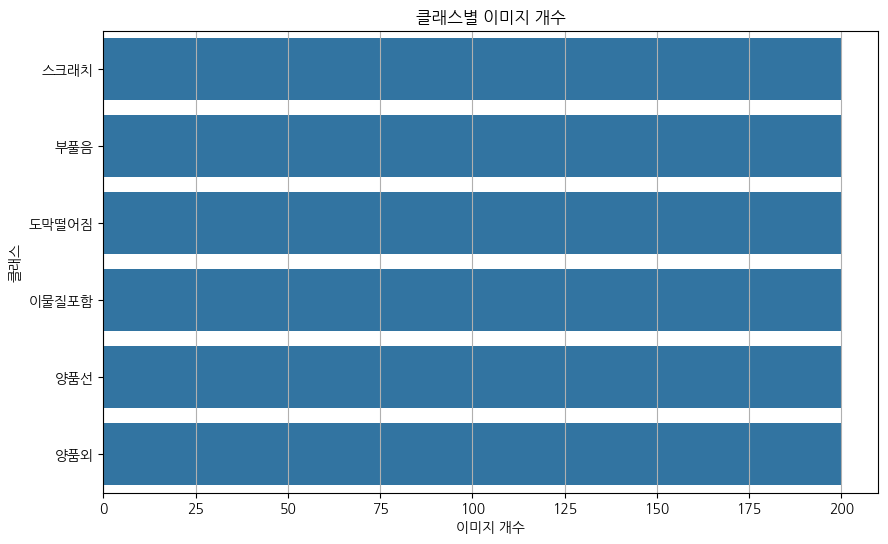

In [7]:
# 클래스별 이미지 개수 확인
plt.figure(figsize=(10, 6))
sns.countplot(y="label", data=df, order=df["label"].value_counts().index)
plt.title("클래스별 이미지 개수")
plt.xlabel("이미지 개수")
plt.ylabel("클래스")
plt.grid(axis="x")
plt.show()
# 모든 클래스 이미지 200개씩 같음

--- [ 스크래치 ] 이미지 샘플 ---


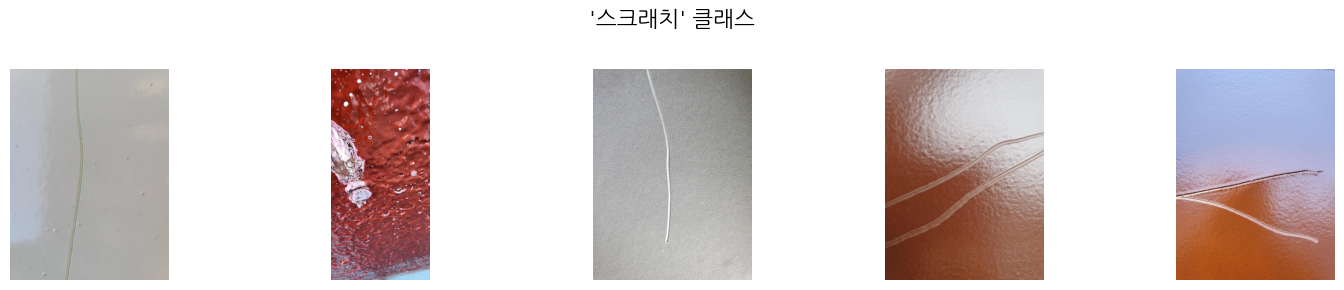



--- [ 부풀음 ] 이미지 샘플 ---


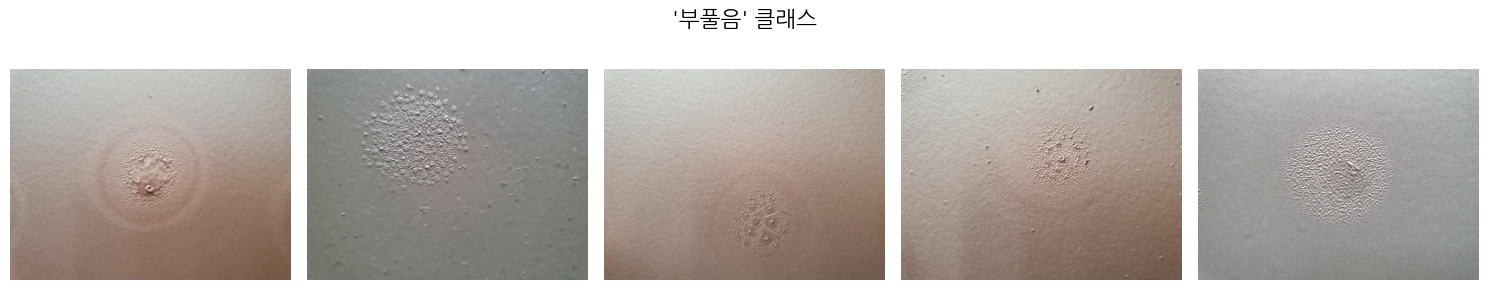



--- [ 도막떨어짐 ] 이미지 샘플 ---


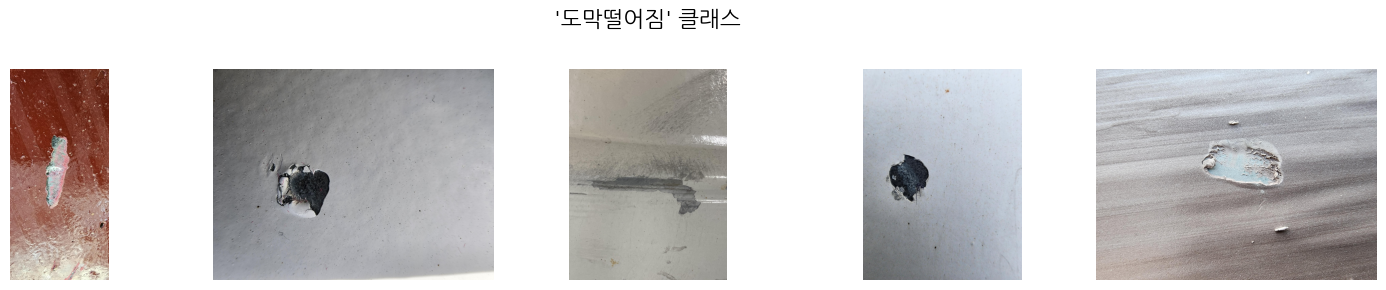



--- [ 이물질포함 ] 이미지 샘플 ---


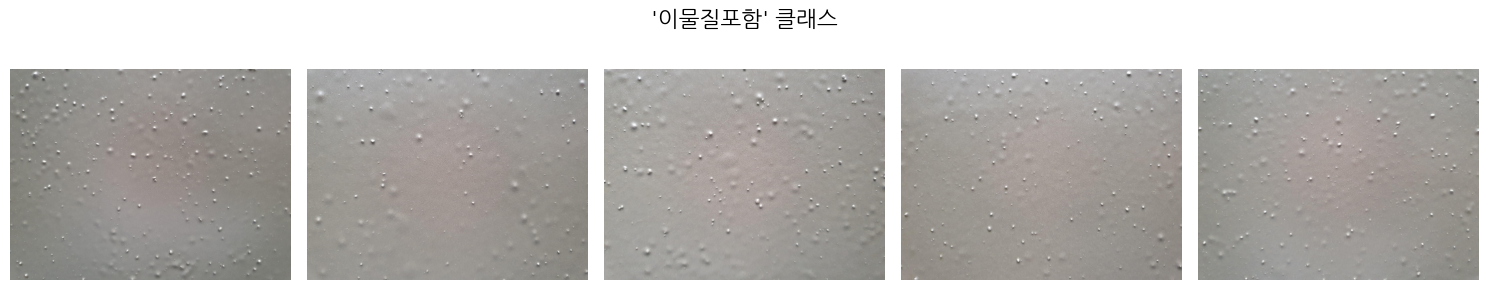



--- [ 양품선 ] 이미지 샘플 ---


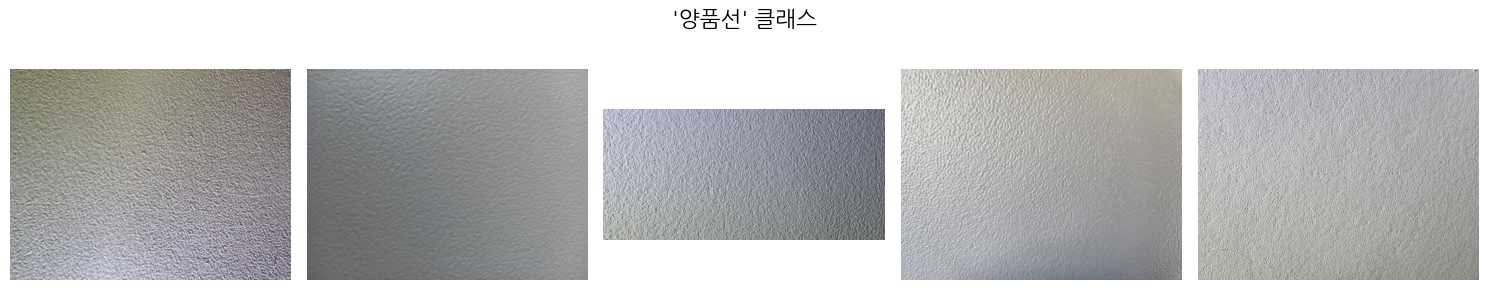



--- [ 양품외 ] 이미지 샘플 ---


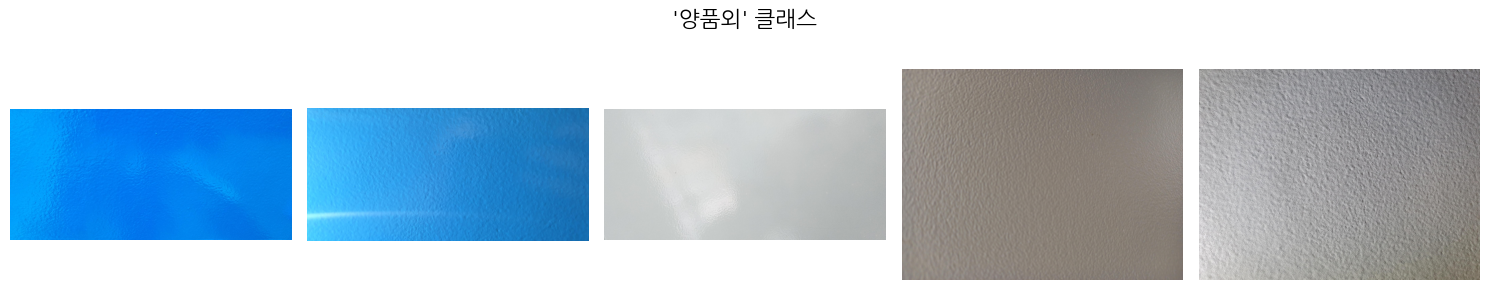

In [8]:
# 각 클래스 폴더를 돌면서 이미지 샘플을 확인.
# folder_to_label 딕셔너리의 키를 사용하여 디렉토리 경로를 구성.
for folder_name, class_name in folder_to_label.items():
    dir_path = CFG["ROOT"] / folder_name
    print(f"--- [ {class_name} ] 이미지 샘플 ---")

    # IMG_EXTS를 사용하여 모든 이미지 파일을 찾기.
    image_paths = []
    # glob으로 한 번에 여러 확장자 찾기
    for ext in IMG_EXTS:
        image_paths.extend(list(dir_path.glob(f"*{ext}")))

    # 보여줄 이미지 개수 (최대 5개)
    num_samples = min(len(image_paths), 5)

    # 이미지가 하나도 없으면 다음 폴더로
    if num_samples == 0:
        print("이미지가 없습니다.")
        continue

    # 무작위로 5개의 이미지를 선택.
    random_images = random.sample(image_paths, num_samples)

    # 1행 num_samples 열의 이미지 플롯(plot)을 생성.
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    # 샘플 이미지를 하나씩 화면에 표시
    for i, img_path in enumerate(random_images):
        # 이미지 열기
        img = Image.open(img_path)

        # 해당 축(subplot)에 이미지 표시
        # 만약 axes가 단일 객체일 경우(이미지가 하나일 때)를 대비하여 조건 처리
        ax = axes[i] if num_samples > 1 else axes
        ax.imshow(img)
        ax.axis("off")

    # 전체 플롯의 제목 설정
    fig.suptitle(f"'{class_name}' 클래스", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # 제목과 겹치지 않도록 레이아웃 조정
    plt.show()
    print("\n")  # 클래스별 구분을 위해 줄바꿈 추가

In [9]:
def get_image_properties(path):
    """이미지 경로를 받아 너비, 높이, 모드를 반환하는 함수"""
    try:
        with Image.open(path) as img:
            return img.width, img.height, img.mode
    except Exception as e:
        print(f"오류 발생: {path}, {e}")
        return None, None, None


# progress_apply를 사용하여 각 이미지의 속성을 계산하고 새 컬럼에 저장
tqdm.pandas() # 진행 상태 확인
df[["width", "height", "mode"]] = df["path"].progress_apply(
    lambda path: pd.Series(get_image_properties(path))
)

print("\n\n--- 이미지 크기 통계 ---")
print(df[["width", "height"]].describe())

print("\n\n--- 이미지 모드(채널) 분포 ---")
print(df["mode"].value_counts())

100%|██████████| 1200/1200 [00:01<00:00, 835.83it/s] 



--- 이미지 크기 통계 ---
            width       height
count  1200.00000  1200.000000
mean   2699.88750  2212.416667
std     302.63918   372.842298
min    1272.00000  1272.000000
25%    2828.00000  2138.000000
50%    2851.00000  2138.000000
75%    2851.00000  2138.000000
max    2851.00000  2851.000000


--- 이미지 모드(채널) 분포 ---
mode
RGB    1200
Name: count, dtype: int64


1. 이미지크기가 평균 2700x2200 정도의 고해상도 이미지
2. 모두 RGB

In [10]:
# 특성(X)과 라벨(y) 정의
X = df["path"]
y = df["label"]

# 훈련 데이터와 검증 데이터로 분할 (80% 훈련, 20% 검증)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=CFG["SEED"], stratify=y
)

print(f"훈련 데이터 샘플 수: {len(X_train)}")
print(f"검증 데이터 샘플 수: {len(X_val)}")
print("\n훈련 데이터 라벨 분포:")
print(y_train.value_counts())
print("\n검증 데이터 라벨 분포:")
print(y_val.value_counts())

훈련 데이터 샘플 수: 960
검증 데이터 샘플 수: 240

훈련 데이터 라벨 분포:
label
부풀음      160
스크래치     160
양품외      160
도막떨어짐    160
양품선      160
이물질포함    160
Name: count, dtype: int64

검증 데이터 라벨 분포:
label
도막떨어짐    40
양품외      40
이물질포함    40
스크래치     40
부풀음      40
양품선      40
Name: count, dtype: int64


## 데이터 변환(Transform)

In [11]:
# --------------------------------------------------------------------------
# 1. 모든 클래스에 적용할 통합 기본 파이프라인
# --------------------------------------------------------------------------
train_transform = A.Compose(
    [
        # 이미지 크기를 224x224로 조정
        A.Resize(CFG["IMG_SIZE"], CFG["IMG_SIZE"]),
        # 50% 확률로 좌우 반전을 적용
        A.HorizontalFlip(p=0.5),
        # 50% 확률로 상하 반전을 적용. 선박 도장 결함들은 방향에 무관
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        # 기하학적 변형 추가
        A.ShiftScaleRotate(p=0.5, shift_limit=0.1, scale_limit=0.1, rotate_limit=30),
        # 밝기, 대비, 색상 변형 추가
        A.RandomBrightnessContrast(p=0.7, brightness_limit=0.2, contrast_limit=0.2),
        A.ColorJitter(p=0.5),
        # 이미지 일부를 가리는 변형 추가
        A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.5),
        # ImageNet 평균/표준편차로 정규화를 수행.
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        # 이미지를 PyTorch 텐서로 변환.
        ToTensorV2(),
    ]
)


# 검증(Validation) 데이터용 파이프라인은 그대로 유지.
val_transform = A.Compose(
    [
        A.Resize(CFG["IMG_SIZE"], CFG["IMG_SIZE"]),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [12]:
# --------------------------------------------------------------------------
# 2. 범용 Augmentation을 적용하는 표준 Custom Dataset
# --------------------------------------------------------------------------


class ShipDefectDataset(Dataset):

    def __init__(self, image_paths, labels, class_to_idx, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.class_to_idx = class_to_idx
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # 이미지 경로와 라벨(클래스 이름) 가져오기
        image_path = self.image_paths[idx]
        # 라벨이 None인 경우(예: 테스트 데이터셋)를 처리
        class_name = self.labels[idx] if self.labels is not None else None

        # 이미지 불러오기 (OpenCV는 BGR 순서)
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 전달받은 transform이 있으면 적용
        if self.transform:
            augmented_image = self.transform(image=image)["image"]
        else:
            # transform이 없는 경우, 원본 이미지를 반환 (또는 기본 transform 적용)
            augmented_image = image

        # 라벨이 None이 아닐 경우에만 클래스 이름을 정수 인덱스로 변환
        # 라벨이 없는 경우를 나타내기 위해 -1을 사용
        label_idx = self.class_to_idx[class_name] if class_name is not None else -1 # Use -1 or some indicator for no label


        return augmented_image, torch.tensor(label_idx, dtype=torch.long)

In [13]:
# 라벨을 정수 인덱스로 매핑하는 딕셔너리 생성
# 고유한 라벨 목록을 얻고 이를 기반으로 인덱스를 할당
unique_labels = sorted(df["label"].unique())
class_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
print(f"클래스-인덱스 매핑: {class_to_idx}")

클래스-인덱스 매핑: {'도막떨어짐': 0, '부풀음': 1, '스크래치': 2, '양품선': 3, '양품외': 4, '이물질포함': 5}


In [14]:
# 학습용 데이터셋 생성: 통합 기본 파이프라인(train_transform) 적용
train_dataset = ShipDefectDataset(
    image_paths=X_train.tolist(),
    labels=y_train.tolist(),
    class_to_idx=class_to_idx,
    transform=train_transform,
)

# 검증용 데이터셋 생성: 증강 없는 파이프라인(val_transform) 적용
val_dataset = ShipDefectDataset(
    image_paths=X_val.tolist(),
    labels=y_val.tolist(),
    class_to_idx=class_to_idx,
    transform=val_transform,
)

In [15]:
# 데이터로더 생성
train_loader = DataLoader(
    train_dataset,
    batch_size=CFG["BATCH_SIZE"],
    shuffle=True,
    num_workers=2, # 학습 속도 느릴때 증가 시켜보기(예: 2, 4, 8)
    pin_memory=True,  # num_workers > 0 일 때 함께 써주기)
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CFG["BATCH_SIZE"],
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

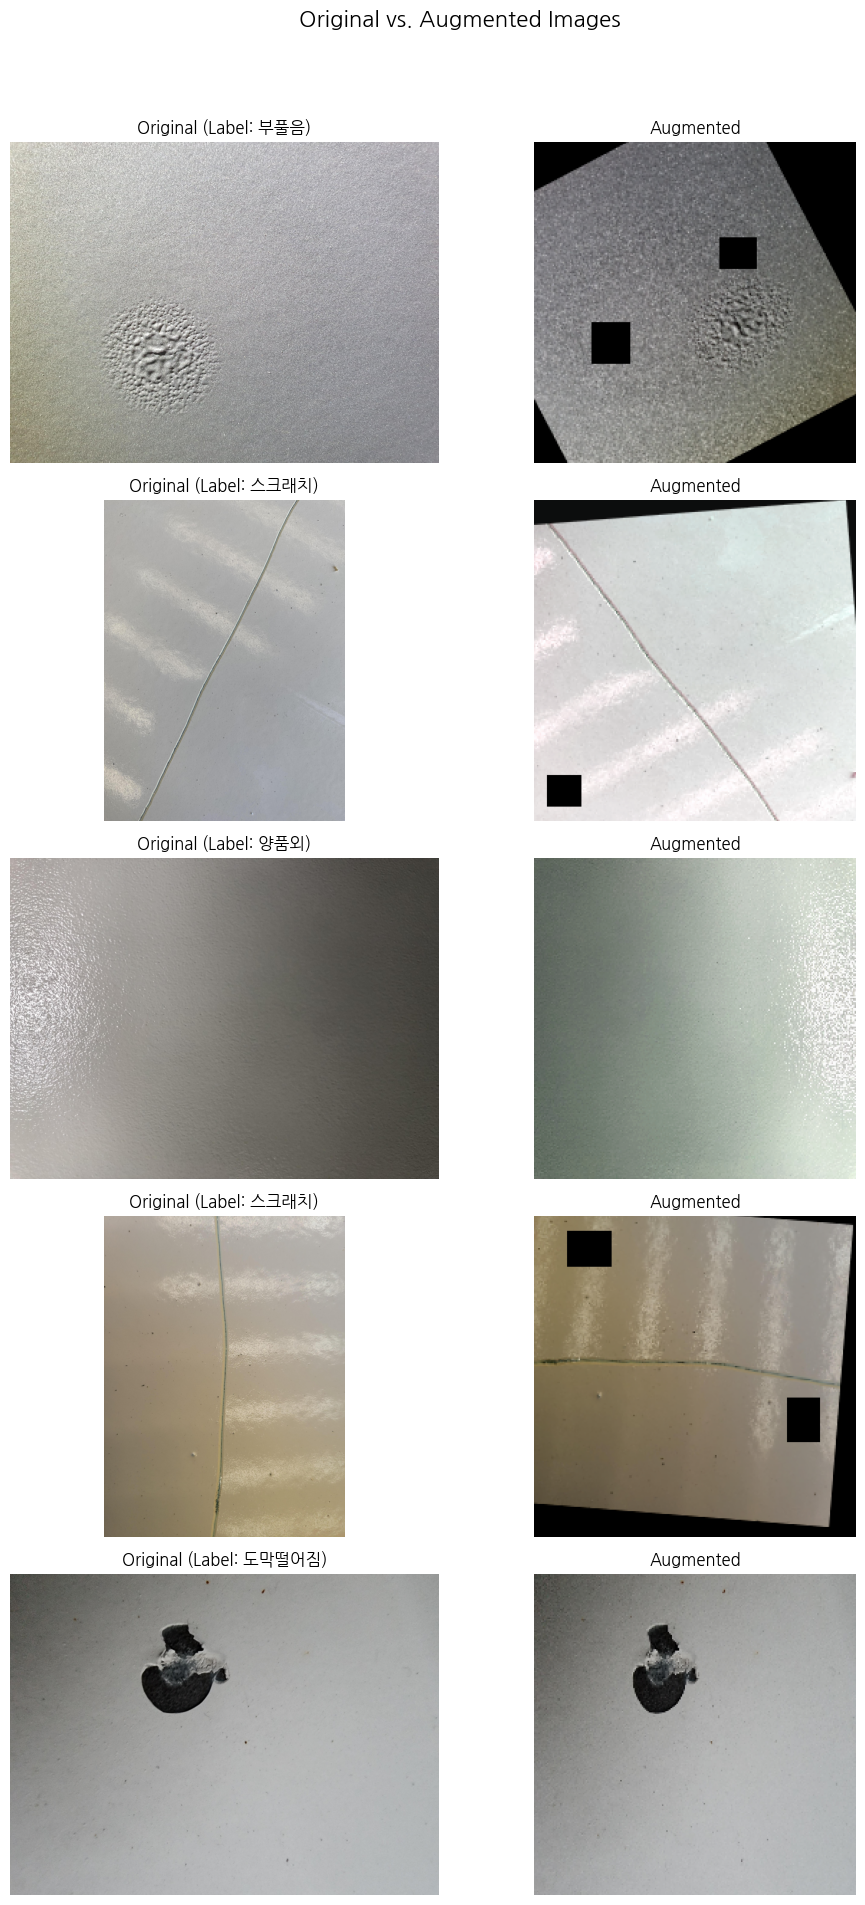

In [16]:
def visualize_augmentation(dataset, idx=0, samples=5):
    """증강 결과를 시각화하는 함수"""

    fig, axes = plt.subplots(samples, 2, figsize=(10, 4 * samples))
    fig.suptitle("Original vs. Augmented Images", fontsize=16)

    for i in range(samples):
        # 원본 이미지를 로드하기 위해 dataset.image_paths 사용
        original_img_path = dataset.image_paths[idx + i]
        original_img = cv2.imread(original_img_path)
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

        # 증강된 이미지와 라벨 가져오기 (Dataset의 __getitem__ 사용)
        augmented_img, label_idx = dataset[idx + i]
        label_name = list(dataset.class_to_idx.keys())[
            list(dataset.class_to_idx.values()).index(label_idx)
        ]

        # Matplotlib으로 시각화하기 위해 역정규화(denormalization)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        # 텐서 차원 변경 (C, H, W) -> (H, W, C)
        augmented_img_np = augmented_img.permute(1, 2, 0).numpy()
        augmented_img_np = std * augmented_img_np + mean
        augmented_img_np = np.clip(
            augmented_img_np, 0, 1
        )  # 픽셀 값을 [0, 1] 범위로 클립

        # 원본 이미지 표시
        axes[i, 0].imshow(original_img)
        axes[i, 0].set_title(f"Original (Label: {label_name})")
        axes[i, 0].axis("off")

        # 증강된 이미지 표시
        axes[i, 1].imshow(augmented_img_np)
        axes[i, 1].set_title("Augmented")
        axes[i, 1].axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# --- 시각화 실행 ---
visualize_augmentation(train_dataset, idx=0, samples=5)

## 모델 학습

모델은 각자 자유롭게 구성할 수 있으며, 올바른 형식으로 `submission.csv`를 작성한다면 다양한 모델이 허용됩니다.

아래는 이해를 돕기 위한 예시 코드로, 간단한 로지스틱 회귀 모델을 사용합니다.

In [17]:
# =================================================================================
# 1. 학습 환경 설정
# =================================================================================
# --- 초기화 (학습 시작 전) ---
# 새로운 실험 실행을 정의합니다.

# 설정값(config) 딕셔너리 정의
config = {
    "model": CFG["MODEL_NAME"],
    "learning_rate": CFG["LEARNING_RATE"],
    "epochs": CFG["EPOCHS"],
    "batch_size": CFG["BATCH_SIZE"],
    "optimizer": "AdamW",  # 옵티마이저 직접 지정
    "weight_decay": 1e-2,  # 가중치 감쇠(Weight decay) 직접 지정
    "scheduler": "linear_schedule_with_warmup",  # 스케줄러 직접 지정
    "image_size": CFG["IMG_SIZE"],
    "augmentation": "base_transform_v2",  # 데이터 증강(Augmentation) 이름 직접 지정
}

# # WandB(Weights & Biases) 실행 초기화
# run = wandb.init(
#     project="ship-defect-classification",  # 프로젝트 이름
#     name=f"{config['model']}_{config['augmentation']}_lr_{config['learning_rate']}_{config['scheduler']}",  # 실험의 고유 이름 (직접 지정)
#     config=config,  # 실험에 사용된 모든 하이퍼파라미터를 기록
# )

In [25]:
def train(model, optimizer, scheduler, train_loader, val_loader, device, wandb=None):
    """전체 훈련 과정을 관리하는 메인 함수입니다."""
    # 손실 함수 정의
    criterion = nn.CrossEntropyLoss().to(CFG['DEVICE'])
    
    # 최고 점수 및 저장 경로 초기화
    best_macro_f1 = 0.0

    safe_model_name = CFG['MODEL_NAME'].replace(':', '-').replace('/', '_')
    checkpoint_dir = Path(f"./checkpoints/{safe_model_name}")
    checkpoint_interval = 10 # 기본 10 에폭마다 저장
    checkpoint_dir.mkdir(exist_ok=True)
    print("======== Training Start ========")
    for epoch in range(CFG["EPOCHS"]):
        
        # --- 1. 훈련 ---
        model.train()
        train_loss = 0.0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{CFG['EPOCHS']} Training"):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            if scheduler is not None:
                scheduler.step()
            
            train_loss += loss.item()
        avg_train_loss = train_loss / len(train_loader)

        # --- 2. 검증 ---
        avg_val_loss, val_accuracy, macro_f1 = validation(model, criterion, val_loader, device)

        # --- 3. 결과 출력 및 로깅 ---
        print(f"Epoch {epoch+1}/{CFG['EPOCHS']}")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val Macro F1: {macro_f1:.4f}")
        
        if wandb:
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": avg_train_loss,
                "val_loss": avg_val_loss,
                "val_accuracy": val_accuracy,
                "macro_f1_score": macro_f1,
                "learning_rate": optimizer.param_groups[0]['lr'],
            })

        # --- 4. 최고 성능 모델 저장 ---
        if macro_f1 > best_macro_f1:
            print(f"  >> New best F1 Score ({macro_f1:.4f}), saving model...")
            best_macro_f1 = macro_f1
            model_save_path = checkpoint_dir / f"{safe_model_name}_best_f1_model.pth"
            torch.save(model.state_dict(), model_save_path)
            
        # --- 5. 주기적 체크포인트 저장 (수정된 부분) ---
        if (epoch + 1) % checkpoint_interval == 0:
            checkpoint_path = checkpoint_dir / f"checkpoint_epoch_{epoch+1}.pth"
            print(f"  >> Saving checkpoint at epoch {epoch+1} to {checkpoint_path}...")
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                'best_macro_f1': best_macro_f1,
            }, checkpoint_path)

    print(f"======== Training Finished ========\nBest F1 Score: {best_macro_f1:.4f}")
    
    return model


In [26]:
def validation(model, criterion, val_loader, device):
    """모델 검증을 수행하고, 손실, 정확도, F1 스코어를 반환합니다."""
    model.eval()  # 모델을 평가 모드로 설정
    val_loss = 0.0
    all_preds = []
    all_labels = []

    # 기울기 계산 비활성화
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 평균 손실, 정확도, 매크로 F1 스코어 계산
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    macro_f1 = f1_score(all_labels, all_preds, average='macro')

    return avg_val_loss, val_accuracy, macro_f1

In [27]:
# model 정의
model = timm.create_model(
    CFG["MODEL_NAME"],
    pretrained=True,
    num_classes=CFG["NUM_CLASSES"],
)
model.to(CFG["DEVICE"])

RegNet(
  (stem): ConvNormAct(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (s1): RegStage(
    (b1): Bottleneck(
      (conv1): ConvNormAct(
        (conv): Conv2d(32, 224, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
      )
      (conv2): ConvNormAct(
        (conv): Conv2d(224, 224, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=2, bias=False)
        (bn): BatchNormAct2d(
          224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
      )
      (se): SEModule(
        (fc1): Conv2d(224, 8,

In [28]:
# 손실 함수(loss function) 정의, 분류 문제에 주로 사용되는 CrossEntropyLoss를 사용
criterion = nn.CrossEntropyLoss()
# 최적화 도구(optimizer) 정의: AdamW 옵티마이저를 사용
optimizer = torch.optim.AdamW(
    model.parameters(), lr=CFG["LEARNING_RATE"], weight_decay=config["weight_decay"]
)

# 1. 전체 학습 스텝(iteration) 수 계산
num_training_steps = len(train_loader) * CFG["EPOCHS"]
# 2. Warm-up 스텝 수 설정 (보통 전체 스텝의 5~10%)
num_warmup_steps = int(num_training_steps * 0.05)

# Warm-up 후 선형(Linear) 형태로 감소
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps
)

In [29]:
model = train(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    device=CFG['DEVICE']
)

======== Training Start ========


Validation: 100%|██████████| 15/15 [00:06<00:00,  2.16it/s]


Epoch 1/80
  Train Loss: 1.7210
  Val Loss: 1.3923, Val Accuracy: 0.7167, Val Macro F1: 0.6928
  >> New best F1 Score (0.6928), saving model...


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.13it/s]


Epoch 2/80
  Train Loss: 0.8482
  Val Loss: 0.3143, Val Accuracy: 0.8917, Val Macro F1: 0.8903
  >> New best F1 Score (0.8903), saving model...


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.07it/s]


Epoch 3/80
  Train Loss: 0.3255
  Val Loss: 0.3732, Val Accuracy: 0.8417, Val Macro F1: 0.8384


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


Epoch 4/80
  Train Loss: 0.3102
  Val Loss: 0.2622, Val Accuracy: 0.8875, Val Macro F1: 0.8869


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


Epoch 5/80
  Train Loss: 0.3102
  Val Loss: 0.2816, Val Accuracy: 0.8625, Val Macro F1: 0.8610


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Epoch 6/80
  Train Loss: 0.2911
  Val Loss: 0.2514, Val Accuracy: 0.8792, Val Macro F1: 0.8714


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.11it/s]


Epoch 7/80
  Train Loss: 0.2537
  Val Loss: 0.4099, Val Accuracy: 0.8500, Val Macro F1: 0.8464


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.13it/s]


Epoch 8/80
  Train Loss: 0.2434
  Val Loss: 0.2083, Val Accuracy: 0.9167, Val Macro F1: 0.9167
  >> New best F1 Score (0.9167), saving model...


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


Epoch 9/80
  Train Loss: 0.2357
  Val Loss: 0.2351, Val Accuracy: 0.8958, Val Macro F1: 0.8950


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.14it/s]


Epoch 10/80
  Train Loss: 0.2798
  Val Loss: 0.2690, Val Accuracy: 0.9083, Val Macro F1: 0.9079
  >> Saving checkpoint at epoch 10 to checkpoints/hf_hub-timm_regnety_120.sw_in12k_ft_in1k/checkpoint_epoch_10.pth...


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Epoch 11/80
  Train Loss: 0.1960
  Val Loss: 0.2684, Val Accuracy: 0.8917, Val Macro F1: 0.8853


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.14it/s]


Epoch 12/80
  Train Loss: 0.2268
  Val Loss: 0.2037, Val Accuracy: 0.9125, Val Macro F1: 0.9113


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


Epoch 13/80
  Train Loss: 0.2028
  Val Loss: 0.2420, Val Accuracy: 0.8958, Val Macro F1: 0.8965


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


Epoch 14/80
  Train Loss: 0.2015
  Val Loss: 0.2189, Val Accuracy: 0.8792, Val Macro F1: 0.8760


Validation: 100%|██████████| 15/15 [00:06<00:00,  2.15it/s]


Epoch 15/80
  Train Loss: 0.1950
  Val Loss: 0.2432, Val Accuracy: 0.9125, Val Macro F1: 0.9116


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.11it/s]


Epoch 16/80
  Train Loss: 0.2156
  Val Loss: 0.1638, Val Accuracy: 0.9333, Val Macro F1: 0.9331
  >> New best F1 Score (0.9331), saving model...


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.04it/s]


Epoch 17/80
  Train Loss: 0.1484
  Val Loss: 0.2375, Val Accuracy: 0.9125, Val Macro F1: 0.9119


Validation: 100%|██████████| 15/15 [00:07<00:00,  1.97it/s]


Epoch 18/80
  Train Loss: 0.1601
  Val Loss: 0.1889, Val Accuracy: 0.9208, Val Macro F1: 0.9206


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.03it/s]


Epoch 19/80
  Train Loss: 0.1853
  Val Loss: 0.2722, Val Accuracy: 0.9208, Val Macro F1: 0.9212


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


Epoch 20/80
  Train Loss: 0.1640
  Val Loss: 0.1924, Val Accuracy: 0.9167, Val Macro F1: 0.9167
  >> Saving checkpoint at epoch 20 to checkpoints/hf_hub-timm_regnety_120.sw_in12k_ft_in1k/checkpoint_epoch_20.pth...


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.03it/s]


Epoch 21/80
  Train Loss: 0.1954
  Val Loss: 0.1634, Val Accuracy: 0.9333, Val Macro F1: 0.9325


Validation: 100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


Epoch 22/80
  Train Loss: 0.1773
  Val Loss: 0.2122, Val Accuracy: 0.9250, Val Macro F1: 0.9239


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]


Epoch 23/80
  Train Loss: 0.1519
  Val Loss: 0.1930, Val Accuracy: 0.9292, Val Macro F1: 0.9291


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.07it/s]


Epoch 24/80
  Train Loss: 0.1462
  Val Loss: 0.2341, Val Accuracy: 0.8958, Val Macro F1: 0.8953


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.07it/s]


Epoch 25/80
  Train Loss: 0.1287
  Val Loss: 0.2039, Val Accuracy: 0.9208, Val Macro F1: 0.9203


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.05it/s]


Epoch 26/80
  Train Loss: 0.1288
  Val Loss: 0.1644, Val Accuracy: 0.9333, Val Macro F1: 0.9327


Validation: 100%|██████████| 15/15 [00:07<00:00,  1.91it/s]


Epoch 27/80
  Train Loss: 0.1289
  Val Loss: 0.1459, Val Accuracy: 0.9417, Val Macro F1: 0.9415
  >> New best F1 Score (0.9415), saving model...


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Epoch 28/80
  Train Loss: 0.1280
  Val Loss: 0.1548, Val Accuracy: 0.9583, Val Macro F1: 0.9581
  >> New best F1 Score (0.9581), saving model...


Validation: 100%|██████████| 15/15 [00:06<00:00,  2.15it/s]


Epoch 29/80
  Train Loss: 0.1233
  Val Loss: 0.2142, Val Accuracy: 0.9208, Val Macro F1: 0.9206


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.13it/s]


Epoch 30/80
  Train Loss: 0.1180
  Val Loss: 0.1575, Val Accuracy: 0.9500, Val Macro F1: 0.9500
  >> Saving checkpoint at epoch 30 to checkpoints/hf_hub-timm_regnety_120.sw_in12k_ft_in1k/checkpoint_epoch_30.pth...


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


Epoch 31/80
  Train Loss: 0.1058
  Val Loss: 0.2057, Val Accuracy: 0.9167, Val Macro F1: 0.9169


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.06it/s]


Epoch 32/80
  Train Loss: 0.1119
  Val Loss: 0.1996, Val Accuracy: 0.9375, Val Macro F1: 0.9374


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


Epoch 33/80
  Train Loss: 0.1089
  Val Loss: 0.1828, Val Accuracy: 0.9458, Val Macro F1: 0.9456


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.07it/s]


Epoch 34/80
  Train Loss: 0.1247
  Val Loss: 0.1626, Val Accuracy: 0.9208, Val Macro F1: 0.9204


Validation: 100%|██████████| 15/15 [00:06<00:00,  2.15it/s]


Epoch 35/80
  Train Loss: 0.1037
  Val Loss: 0.1613, Val Accuracy: 0.9458, Val Macro F1: 0.9461


Validation: 100%|██████████| 15/15 [00:06<00:00,  2.14it/s]


Epoch 36/80
  Train Loss: 0.1159
  Val Loss: 0.1502, Val Accuracy: 0.9333, Val Macro F1: 0.9333


Validation: 100%|██████████| 15/15 [00:06<00:00,  2.14it/s]


Epoch 37/80
  Train Loss: 0.1029
  Val Loss: 0.1683, Val Accuracy: 0.9375, Val Macro F1: 0.9372


Validation: 100%|██████████| 15/15 [00:06<00:00,  2.15it/s]


Epoch 38/80
  Train Loss: 0.1058
  Val Loss: 0.2495, Val Accuracy: 0.9042, Val Macro F1: 0.9025


Validation: 100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


Epoch 39/80
  Train Loss: 0.0924
  Val Loss: 0.1720, Val Accuracy: 0.9333, Val Macro F1: 0.9332


Validation: 100%|██████████| 15/15 [00:06<00:00,  2.18it/s]


Epoch 40/80
  Train Loss: 0.0713
  Val Loss: 0.1343, Val Accuracy: 0.9583, Val Macro F1: 0.9583
  >> New best F1 Score (0.9583), saving model...
  >> Saving checkpoint at epoch 40 to checkpoints/hf_hub-timm_regnety_120.sw_in12k_ft_in1k/checkpoint_epoch_40.pth...


Validation: 100%|██████████| 15/15 [00:06<00:00,  2.14it/s]


Epoch 41/80
  Train Loss: 0.0885
  Val Loss: 0.1717, Val Accuracy: 0.9333, Val Macro F1: 0.9331


Validation: 100%|██████████| 15/15 [00:06<00:00,  2.15it/s]


Epoch 42/80
  Train Loss: 0.0959
  Val Loss: 0.1780, Val Accuracy: 0.9375, Val Macro F1: 0.9375


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Epoch 43/80
  Train Loss: 0.0806
  Val Loss: 0.1450, Val Accuracy: 0.9542, Val Macro F1: 0.9542


Validation: 100%|██████████| 15/15 [00:06<00:00,  2.16it/s]


Epoch 44/80
  Train Loss: 0.1015
  Val Loss: 0.1941, Val Accuracy: 0.9417, Val Macro F1: 0.9424


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


Epoch 45/80
  Train Loss: 0.0953
  Val Loss: 0.1633, Val Accuracy: 0.9375, Val Macro F1: 0.9371


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


Epoch 46/80
  Train Loss: 0.0812
  Val Loss: 0.1466, Val Accuracy: 0.9417, Val Macro F1: 0.9416


Validation: 100%|██████████| 15/15 [00:06<00:00,  2.15it/s]


Epoch 47/80
  Train Loss: 0.0619
  Val Loss: 0.1840, Val Accuracy: 0.9583, Val Macro F1: 0.9580


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.13it/s]


Epoch 48/80
  Train Loss: 0.0740
  Val Loss: 0.1827, Val Accuracy: 0.9375, Val Macro F1: 0.9369


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.07it/s]


Epoch 49/80
  Train Loss: 0.0489
  Val Loss: 0.1666, Val Accuracy: 0.9500, Val Macro F1: 0.9496


Validation: 100%|██████████| 15/15 [00:06<00:00,  2.15it/s]


Epoch 50/80
  Train Loss: 0.0778
  Val Loss: 0.1506, Val Accuracy: 0.9583, Val Macro F1: 0.9582
  >> Saving checkpoint at epoch 50 to checkpoints/hf_hub-timm_regnety_120.sw_in12k_ft_in1k/checkpoint_epoch_50.pth...


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.04it/s]


Epoch 51/80
  Train Loss: 0.0687
  Val Loss: 0.1204, Val Accuracy: 0.9625, Val Macro F1: 0.9623
  >> New best F1 Score (0.9623), saving model...


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.01it/s]


Epoch 52/80
  Train Loss: 0.0636
  Val Loss: 0.1477, Val Accuracy: 0.9500, Val Macro F1: 0.9494


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.11it/s]


Epoch 53/80
  Train Loss: 0.0546
  Val Loss: 0.1305, Val Accuracy: 0.9542, Val Macro F1: 0.9539


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.14it/s]


Epoch 54/80
  Train Loss: 0.0697
  Val Loss: 0.2009, Val Accuracy: 0.9542, Val Macro F1: 0.9538


Validation: 100%|██████████| 15/15 [00:07<00:00,  1.99it/s]


Epoch 55/80
  Train Loss: 0.0805
  Val Loss: 0.1669, Val Accuracy: 0.9667, Val Macro F1: 0.9666
  >> New best F1 Score (0.9666), saving model...


Validation: 100%|██████████| 15/15 [00:08<00:00,  1.80it/s]


Epoch 56/80
  Train Loss: 0.0571
  Val Loss: 0.1662, Val Accuracy: 0.9500, Val Macro F1: 0.9498


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


Epoch 57/80
  Train Loss: 0.0571
  Val Loss: 0.1767, Val Accuracy: 0.9500, Val Macro F1: 0.9499


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


Epoch 58/80
  Train Loss: 0.0609
  Val Loss: 0.1344, Val Accuracy: 0.9667, Val Macro F1: 0.9666


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.03it/s]


Epoch 59/80
  Train Loss: 0.0447
  Val Loss: 0.1590, Val Accuracy: 0.9625, Val Macro F1: 0.9625


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.07it/s]


Epoch 60/80
  Train Loss: 0.0373
  Val Loss: 0.1544, Val Accuracy: 0.9583, Val Macro F1: 0.9583
  >> Saving checkpoint at epoch 60 to checkpoints/hf_hub-timm_regnety_120.sw_in12k_ft_in1k/checkpoint_epoch_60.pth...


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.02it/s]


Epoch 61/80
  Train Loss: 0.0398
  Val Loss: 0.1779, Val Accuracy: 0.9500, Val Macro F1: 0.9498


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


Epoch 62/80
  Train Loss: 0.0446
  Val Loss: 0.1778, Val Accuracy: 0.9667, Val Macro F1: 0.9666


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.06it/s]


Epoch 63/80
  Train Loss: 0.0409
  Val Loss: 0.1905, Val Accuracy: 0.9625, Val Macro F1: 0.9623


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


Epoch 64/80
  Train Loss: 0.0404
  Val Loss: 0.2091, Val Accuracy: 0.9583, Val Macro F1: 0.9583


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


Epoch 65/80
  Train Loss: 0.0498
  Val Loss: 0.1841, Val Accuracy: 0.9625, Val Macro F1: 0.9625


Validation: 100%|██████████| 15/15 [00:07<00:00,  1.93it/s]


Epoch 66/80
  Train Loss: 0.0429
  Val Loss: 0.1630, Val Accuracy: 0.9583, Val Macro F1: 0.9581


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.05it/s]


Epoch 67/80
  Train Loss: 0.0388
  Val Loss: 0.1673, Val Accuracy: 0.9667, Val Macro F1: 0.9666
  >> New best F1 Score (0.9666), saving model...


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Epoch 68/80
  Train Loss: 0.0326
  Val Loss: 0.1686, Val Accuracy: 0.9417, Val Macro F1: 0.9417


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Epoch 69/80
  Train Loss: 0.0393
  Val Loss: 0.1882, Val Accuracy: 0.9500, Val Macro F1: 0.9501


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


Epoch 70/80
  Train Loss: 0.0221
  Val Loss: 0.1642, Val Accuracy: 0.9583, Val Macro F1: 0.9584
  >> Saving checkpoint at epoch 70 to checkpoints/hf_hub-timm_regnety_120.sw_in12k_ft_in1k/checkpoint_epoch_70.pth...


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Epoch 71/80
  Train Loss: 0.0299
  Val Loss: 0.1743, Val Accuracy: 0.9625, Val Macro F1: 0.9623


Validation: 100%|██████████| 15/15 [00:07<00:00,  1.91it/s]


Epoch 72/80
  Train Loss: 0.0335
  Val Loss: 0.1670, Val Accuracy: 0.9583, Val Macro F1: 0.9582


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.04it/s]


Epoch 73/80
  Train Loss: 0.0252
  Val Loss: 0.1625, Val Accuracy: 0.9625, Val Macro F1: 0.9623


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.07it/s]


Epoch 74/80
  Train Loss: 0.0218
  Val Loss: 0.1780, Val Accuracy: 0.9583, Val Macro F1: 0.9580


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Epoch 75/80
  Train Loss: 0.0271
  Val Loss: 0.1668, Val Accuracy: 0.9583, Val Macro F1: 0.9583


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Epoch 76/80
  Train Loss: 0.0289
  Val Loss: 0.1775, Val Accuracy: 0.9625, Val Macro F1: 0.9624


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


Epoch 77/80
  Train Loss: 0.0151
  Val Loss: 0.1664, Val Accuracy: 0.9625, Val Macro F1: 0.9623


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.11it/s]


Epoch 78/80
  Train Loss: 0.0195
  Val Loss: 0.1695, Val Accuracy: 0.9583, Val Macro F1: 0.9582


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.03it/s]


Epoch 79/80
  Train Loss: 0.0249
  Val Loss: 0.1680, Val Accuracy: 0.9583, Val Macro F1: 0.9583


Validation: 100%|██████████| 15/15 [00:07<00:00,  1.90it/s]


Epoch 80/80
  Train Loss: 0.0166
  Val Loss: 0.1720, Val Accuracy: 0.9625, Val Macro F1: 0.9624
  >> Saving checkpoint at epoch 80 to checkpoints/hf_hub-timm_regnety_120.sw_in12k_ft_in1k/checkpoint_epoch_80.pth...
======== Training Finished ========
Best F1 Score: 0.9666


## 모델 평가 및 결과 저장

분류 모델을 평가하기 위한 지표는 다양하게 있으며, 저희는 그 중에서 **F1 Score**를 사용합니다.

여러분들이 작성하신 모델의 성능을 평가하기 위해서는, 지시사항에서 명시한 대로 **테스트 데이터**를 불러와서 예측을 수행하고, 그 결과를 반드시 `submission.csv` 파일에 기록하여 제출해야 합니다.

`submission.csv` 파일은 채점을 위한 코드입니다. index로는 테스트 데이터의 파일 이름들을, "label"열에는 해당 이미지 파일의 손상 종류를 저장해야 합니다. 아래와 같은 형태의 데이터프레임을 만든 뒤 `submission.csv` 파일로 저장해야 합니다.
* 아래 데이터프레임은 예시입니다.
   
|      | label |
| --------- | ----- |
| 00001.jpg | 양품    |
| 00002.jpg | 스크래치    |
| 00003.jpg | 양품    |
| 00004.jpg | 도막떨어짐    |
| 00005.jpg | 양품    |

In [31]:
# 1. best model 로드
# Define the path to the best model checkpoint
safe_model_name = CFG['MODEL_NAME'].replace(':', '-').replace('/', '_')
checkpoint_dir = Path(f"./checkpoints/{safe_model_name}")
best_model_path = checkpoint_dir / f"{safe_model_name}_best_f1_model.pth"

# Load the model state dictionary
model.load_state_dict(torch.load(best_model_path))
model.to(CFG["DEVICE"]) 
print(f"✅ Best model loaded from {best_model_path}")

✅ Best model loaded from checkpoints/hf_hub-timm_regnety_120.sw_in12k_ft_in1k/hf_hub-timm_regnety_120.sw_in12k_ft_in1k_best_f1_model.pth


In [32]:
# 2. 테스트 데이터셋 준비
TEST_ROOT = CFG["ROOT"] / "제출용 데이터"
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp"}

# 테스트 이미지 경로 수집
test_image_paths = []
for p in TEST_ROOT.rglob("*"):
    if p.is_file() and p.suffix.lower() in IMG_EXTS:
        test_image_paths.append(str(p))

#  파일명을 기준으로 경로를 정렬하여 일관된 순서 유지
test_image_paths = sorted(test_image_paths, key=lambda x: Path(x).name)

# 테스트 데이터셋을 위한 임시 라벨 리스트 생성 (추론 시에는 실제 라벨이 없음)
# 추론에는 이미지 경로만 필요함
test_labels_dummy = [None] * len(test_image_paths)

# 검증용 transform을 사용하여 테스트 데이터셋 생성
test_dataset = ShipDefectDataset(
    image_paths=test_image_paths,
    labels=test_labels_dummy, # Dummy labels
    class_to_idx=class_to_idx, # Use the same class_to_idx mapping
    transform=val_transform, # Use validation transform (no augmentation)
)

# 테스트 데이터로더 생성
test_loader = DataLoader(
    test_dataset,
    batch_size=CFG["BATCH_SIZE"],
    shuffle=False, # No need to shuffle test data
    # num_workers=4,
    # pin_memory=True,
)

print(f"✅ {len(test_image_paths)}개의 이미지로 테스트 데이터셋 준비 완료.")

✅ 1000개의 이미지로 테스트 데이터셋 준비 완료.


In [33]:
# 3. 추론 수행
model.eval()  # 모델을 평가 모드로 설정
test_preds = []
test_filenames = []

with torch.no_grad():
    for images, _ in tqdm(test_loader, desc="Predicting on test set"):
        images = images.to(CFG["DEVICE"]) # 이미지를 지정된 장치(GPU 등)로 이동
        outputs = model(images) # 모델에 이미지를 입력하여 결과(logits) 출력
        _, preds = torch.max(outputs, 1) # 가장 높은 값을 가진 인덱스를 예측 클래스로 확정
        test_preds.extend(preds.cpu().numpy()) # 예측 결과를 CPU로 옮겨 numpy 배열로 변환 후 리스트에 추가

# 전체 테스트 이미지 경로에서 파일명만 추출
test_filenames = [Path(p).name for p in test_image_paths]

print("✅ 추론 완료.")

Predicting on test set: 100%|██████████| 63/63 [00:32<00:00,  1.94it/s]

✅ 추론 완료.


In [34]:
# 4. 예측 결과 처리
# 예측된 인덱스를 다시 클래스 이름으로 변환
idx_to_class = {idx: label for label, idx in class_to_idx.items()}
predicted_class_names = [idx_to_class[pred] for pred in test_preds]

# 5. '양품선'과 '양품외'를 '양품'으로 통합
processed_labels = ["양품" if label in ["양품선", "양품외"] else label for label in predicted_class_names]

print("✅ 예측 결과 처리 완료.")

✅ 예측 결과 처리 완료.


In [35]:
# 6. 제출 파일 생성
# pandas DataFrame 생성
df_submit = pd.DataFrame({"label": processed_labels}, index=test_filenames)

# 일관성을 위해 파일명으로 인덱스 정렬
df_submit = df_submit.sort_index()

# 제출 파일 저장
submission_path = "./submission.csv"
df_submit.to_csv(submission_path, encoding="utf-8")

print(f"✅ 제출 파일이 {submission_path}에 저장되었습니다.")
display(df_submit.head())

✅ 제출 파일이 ./submission.csv에 저장되었습니다.


label
00001.jpg  도막떨어짐
00002.jpg  도막떨어짐
00003.jpg   스크래치
00004.jpg   스크래치
00005.jpg     양품

## 제출 결과 : 0.970409